In [ ]:
import cooltools
import cooltools.lib.plotting

# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import cooler

# import core packages
import warnings
warnings.filterwarnings("ignore")
from itertools import combinations
import os

# import semi-core packages
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
plt.style.use('seaborn-v0_8-poster')
import numpy as np
import pandas as pd
from multiprocessing import Pool

# import open2c libraries
import bioframe

import cooltools

from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.2'):
    raise AssertionError("tutorial relies on cooltools version 0.5.2 or higher,"+
                         "please check your cooltools version and update to the latest")

# count cpus
num_cpus = os.getenv('SLURM_CPUS_PER_TASK')
if not num_cpus:
    num_cpus = os.cpu_count()
num_cpus = int(num_cpus)

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cooler
from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter


Merge the pairs files, keep only the "important" chromosomes and only one header

In [3]:

def filter_pairs_by_specific_chromosomes(input_file, output_file):
    # List of chromosomes to filter
    target_chromosomes = ["2L_JJg14_439","2R_JJg14_439", "3L_JJg14_439", "3R_JJg14_439", "4_JJg14_439", "X_JJg14_439", "Y_JJg14_439", "2L_JJg14_057", "2R_JJg14_057", "3L_JJg14_057", "3R_JJg14_057", "4_JJg14_057", "X_JJg14_057", "Y_JJg14_057"]
    buffer = []
    
    buffer_size = 10000

    with gzip.open(input_file, 'rt') as infile, gzip.open(output_file, 'at') as outfile:
        for line in infile:
            #keep only one header and append the other 2 files without the header
            if line.startswith("#") and input_file == "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/24L004895_PnM1.pairs.gz":  # Process header lines
                # Check if the header line starts with any of the target chromosomes
                if line.startswith("#chromsize"):
                    parts = line.strip().split(" ")
                    if parts[1] in target_chromosomes:
                        #create a new chromosome trans and add it to the header
                        buffer.append(line)
                elif line.startswith("#samheader: @SQ"):
                    parts = line.strip().split(":")
                    parts2 = parts[2].strip().split("LN")
                    if parts2[0].strip() in target_chromosomes:
                        buffer.append(line)
                else:
                    buffer.append(line)

                outfile.writelines(buffer)
                buffer=[]
                continue
            elif line.startswith("#"):
                continue
            parts = line.strip().split("\t")
            # Check if both parts[1] and parts[3] are in the target chromosomes list
            if parts[1] in target_chromosomes and parts[3] in target_chromosomes:

                buffer.append(line)
      
                if len(buffer) >= buffer_size:
                    outfile.writelines(buffer)
                    buffer=[]

        
        
input_file1 = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/24L004895_PnM1.pairs.gz"
input_file2 = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/24L004896_PnM2.pairs.gz"
input_file3 = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/24L004897_PnM3.pairs.gz"
output = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250727_merged_PnMs.filt.pairs.gz"

  
filter_pairs_by_specific_chromosomes(input_file1, output)
filter_pairs_by_specific_chromosomes(input_file2, output)
filter_pairs_by_specific_chromosomes(input_file3, output)


Pairs too cooler:

(PoreC) erikson@deep22:/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools$ cooler cload pairs -c1 2 -p1 3 -c2 4 -p2 5 /data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/diploid_genome.importantChroms.chromsizes:1000 20250727_merged_PnMs.filt.pairs.gz 20250727_merged_PnMs.filt.pairs.cool

"scalings can be calculated from raw, unbalanced coolers"

Reading in the pairs file again and converting the chromosomes to 2R or 2R_trans etc

In [6]:
def filter_pairs_by_specific_chromosomes(input_file, output_file):
    # List of chromosomes to filter
    buffer = []
    
    buffer_size = 10000

    with gzip.open(input_file, 'rt') as infile, gzip.open(output_file, 'wt') as outfile:
        for line in infile:
            if line.startswith("#"):  # Process header lines
                # Check if the header line starts with any of the target chromosomes
                if line.startswith("#chromsize"):
                    parts = line.strip().split(" ")
                    #create a new chromosome trans and add it to the header
                    line = line.replace("_JJg14_057", "_trans")
                    line = line.replace("_JJg14_439", "_trans")
                    buffer.append(line)
                    #and then replace trans with nothing and add the sis chromosomes to header
                    line = line.replace("_trans", "")
                    buffer.append(line)
                    continue
                elif line.startswith("#samheader: @SQ"):
                    parts = line.strip().split(":")
                    parts2 = parts[2].strip().split("LN")
                    line = line.replace("_JJg14_057", "_trans")
                    line = line.replace("_JJg14_439", "_trans")
                    buffer.append(line)
                    line = line.replace("_trans", "")
                    buffer.append(line)
                    continue
                else:
                    buffer.append(line)
                    continue

            parts = line.strip().split("\t")
                
            if parts[1] == parts[3]:
                line = line.replace("_JJg14_057", "")
                line = line.replace("_JJg14_439", "")
            else:
                line = line.replace("_JJg14_057", "_trans")
                line = line.replace("_JJg14_439", "_trans")
            
            buffer.append(line)
    
            if len(buffer) >= buffer_size:
                outfile.writelines(buffer)
                buffer=[]

        outfile.writelines(buffer)


        
        
input_file = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250727_merged_PnMs.filt.pairs.gz"
output_file = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250729_merged_PnMs.filtCisTrans.pairs.gz"

  
filter_pairs_by_specific_chromosomes(input_file, output_file)


Pairs to cool:

(PoreC) erikson@deep22:/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools$ cooler cload pairs -c1 2 -p1 3 -c2 4 -p2 5 /data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/dm6_genome.reduced.chromsizes.reduced:1000 20250729_merged_PnMs.filtCisTrans.pairs.gz 20250729_merged_PnMs.filtCisTrans.pairs.cool


INFO:root:creating a Pool of 2 workers


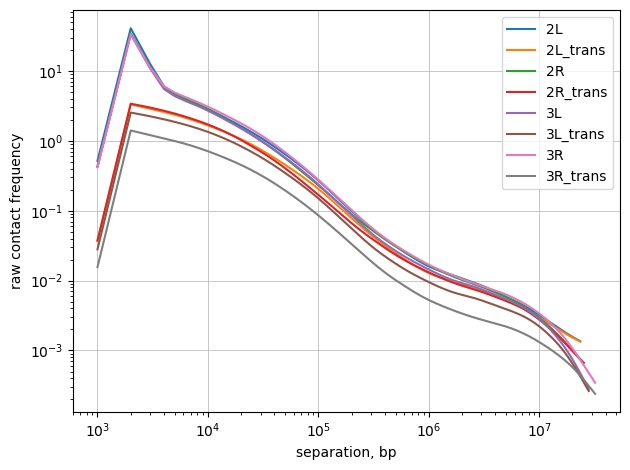

In [11]:
chromsizes_path = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/dm6_genome.reduced.chromsizes.reduced"
chromsizes = pd.read_csv(chromsizes_path, sep="\t", header=None, names=["chrom", "size"])

clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250729_merged_PnMs.filtCisTrans.pairs.cool")

# compute P(s) curves
cvd_smooth_agg = cooltools.expected_cis(
    clr=clr,
    view_df=None,
    smooth=True,
    aggregate_smoothed=True,
    smooth_sigma=0.1,
    nproc=2,
    clr_weight_name=None
    )

# Plot raw (unbalanced) average
fig, ax = plt.subplots(1,1)

for region in chromsizes['chrom']:
    region_data = cvd_smooth_agg[cvd_smooth_agg['region1'] == region]
    ax.loglog(
        region_data['dist_bp'],
        region_data['count.avg.smoothed'],  # ← for unbalanced data
        label=region
    )

ax.set(
    xlabel='separation, bp',
    ylabel='raw contact frequency'
)
ax.set_aspect('auto')  # relaxed aspect for better plotting
ax.grid(True, lw=0.5)
ax.legend(loc='upper right')
plt.tight_layout()

INFO:root:creating a Pool of 2 workers


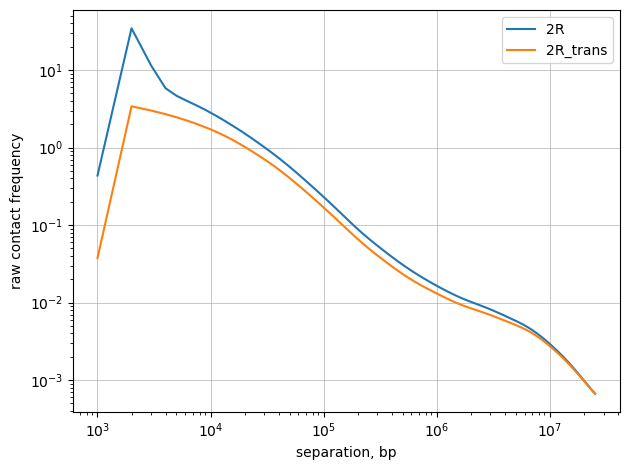

In [19]:
chromsizes_path = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/dm6_genome.reduced.chromsizes.reduced"
chromsizes = pd.read_csv(chromsizes_path, sep="\t", header=None, names=["chrom", "size"])

clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250729_merged_PnMs.filtCisTrans.pairs.cool")

# compute P(s) curves
cvd_smooth_agg = cooltools.expected_cis(
    clr=clr,
    view_df=None,
    smooth=True,
    aggregate_smoothed=True,
    smooth_sigma=0.1,
    nproc=2,
    clr_weight_name=None
)

# Plot raw (unbalanced) average only for 2R and 3R
fig, ax = plt.subplots(1, 1)

for region in ['2R', '2R_trans']:
    region_data = cvd_smooth_agg[cvd_smooth_agg['region1'] == region]
    ax.loglog(
        region_data['dist_bp'],
        region_data['count.avg.smoothed'],  # ← for unbalanced data
        label=region
    )

ax.set(
    xlabel='separation, bp',
    ylabel='raw contact frequency'
)
ax.set_aspect('auto')  # relaxed aspect for better plotting
ax.grid(True, lw=0.5)
ax.legend(loc='upper right')
plt.tight_layout()

INFO:root:creating a Pool of 2 workers


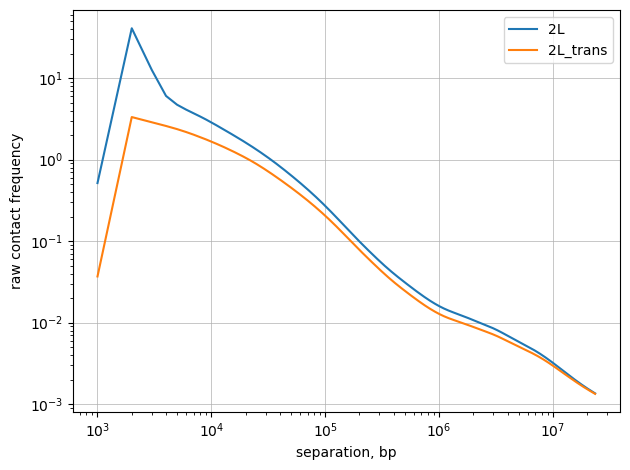

In [21]:
chromsizes_path = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/dm6_genome.reduced.chromsizes.reduced"
chromsizes = pd.read_csv(chromsizes_path, sep="\t", header=None, names=["chrom", "size"])

clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250729_merged_PnMs.filtCisTrans.pairs.cool")

# compute P(s) curves
cvd_smooth_agg = cooltools.expected_cis(
    clr=clr,
    view_df=None,
    smooth=True,
    aggregate_smoothed=True,
    smooth_sigma=0.1,
    nproc=2,
    clr_weight_name=None
)

# Plot raw (unbalanced) average only for 2R and 3R
fig, ax = plt.subplots(1, 1)

for region in ['2L', '2L_trans']:
    region_data = cvd_smooth_agg[cvd_smooth_agg['region1'] == region]
    ax.loglog(
        region_data['dist_bp'],
        region_data['count.avg.smoothed'],  # ← for unbalanced data
        label=region
    )

ax.set(
    xlabel='separation, bp',
    ylabel='raw contact frequency'
)
ax.set_aspect('auto')  # relaxed aspect for better plotting
ax.grid(True, lw=0.5)
ax.legend(loc='upper right')
plt.tight_layout()

INFO:root:creating a Pool of 2 workers


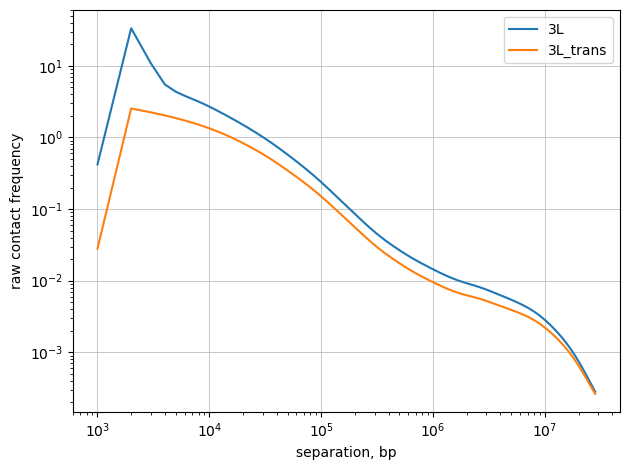

In [22]:
chromsizes_path = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/dm6_genome.reduced.chromsizes.reduced"
chromsizes = pd.read_csv(chromsizes_path, sep="\t", header=None, names=["chrom", "size"])

clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250729_merged_PnMs.filtCisTrans.pairs.cool")

# compute P(s) curves
cvd_smooth_agg = cooltools.expected_cis(
    clr=clr,
    view_df=None,
    smooth=True,
    aggregate_smoothed=True,
    smooth_sigma=0.1,
    nproc=2,
    clr_weight_name=None
)

# Plot raw (unbalanced) average only for 2R and 3R
fig, ax = plt.subplots(1, 1)

for region in ['3L', '3L_trans']:
    region_data = cvd_smooth_agg[cvd_smooth_agg['region1'] == region]
    ax.loglog(
        region_data['dist_bp'],
        region_data['count.avg.smoothed'],  # ← for unbalanced data
        label=region
    )

ax.set(
    xlabel='separation, bp',
    ylabel='raw contact frequency'
)
ax.set_aspect('auto')  # relaxed aspect for better plotting
ax.grid(True, lw=0.5)
ax.legend(loc='upper right')
plt.tight_layout()

INFO:root:creating a Pool of 2 workers


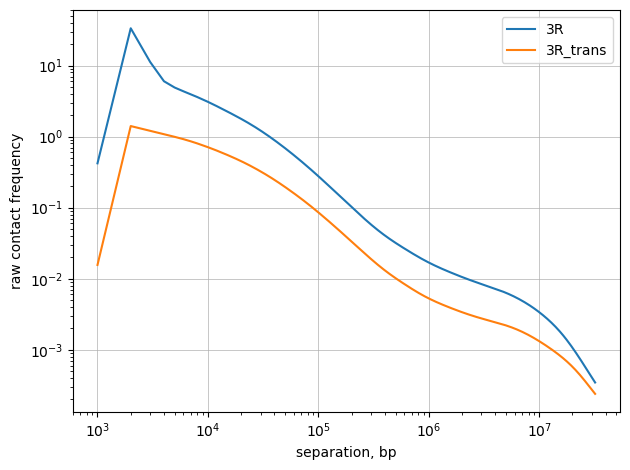

In [23]:
chromsizes_path = "/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/dm6_genome.reduced.chromsizes.reduced"
chromsizes = pd.read_csv(chromsizes_path, sep="\t", header=None, names=["chrom", "size"])

clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250729_merged_PnMs.filtCisTrans.pairs.cool")

# compute P(s) curves
cvd_smooth_agg = cooltools.expected_cis(
    clr=clr,
    view_df=None,
    smooth=True,
    aggregate_smoothed=True,
    smooth_sigma=0.1,
    nproc=2,
    clr_weight_name=None
)

# Plot raw (unbalanced) average only for 2R and 3R
fig, ax = plt.subplots(1, 1)

for region in ['3R', '3R_trans']:
    region_data = cvd_smooth_agg[cvd_smooth_agg['region1'] == region]
    ax.loglog(
        region_data['dist_bp'],
        region_data['count.avg.smoothed'],  # ← for unbalanced data
        label=region
    )

ax.set(
    xlabel='separation, bp',
    ylabel='raw contact frequency'
)
ax.set_aspect('auto')  # relaxed aspect for better plotting
ax.grid(True, lw=0.5)
ax.legend(loc='upper right')
plt.tight_layout()

Balancing

(PoreC) erikson@deep22:/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools$ cooler balance 20250727_merged_PnMs.filt.pairs.cool

(PoreC) erikson@deep22:/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools$ cooler zoomify 20250727_merged_PnMs.filt.pairs.cool -o 20250727_merged_PnMs.filt.pairs.mcool --resolutions 1000,10000,20000,40000,100000



Matrix stats:
Max value: 4410
Min value: 0
NaNs present: False
Rows with all zeros: 2338
Columns with all zeros: 2338


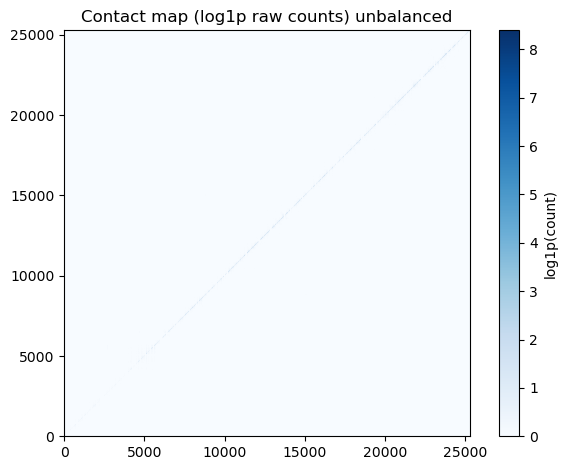

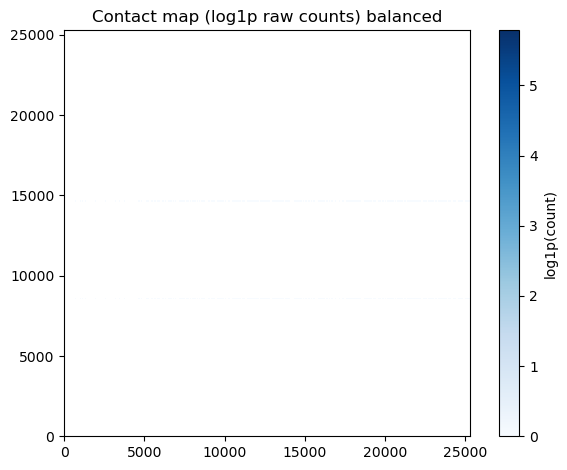

In [8]:
clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250727_merged_PnMs.filt.pairs.cool")


mat = clr.matrix(balance=False).fetch("2R_JJg14_057")

print("Matrix stats:")
print(f"Max value: {np.max(mat)}")
print(f"Min value: {np.min(mat)}")
print(f"NaNs present: {np.isnan(mat).any()}")
print(f"Rows with all zeros: {np.sum(np.all(mat == 0, axis=1))}")
print(f"Columns with all zeros: {np.sum(np.all(mat == 0, axis=0))}")

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts) unbalanced")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

mat = clr.matrix(balance=True).fetch("2R_JJg14_057")
mat = np.clip(mat, 0, np.percentile(mat, 99))  

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts) balanced")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

Trying higher resolutions

Matrix stats:
Max value: 14859
Min value: 0
NaNs present: False
Rows with all zeros: 7
Columns with all zeros: 7


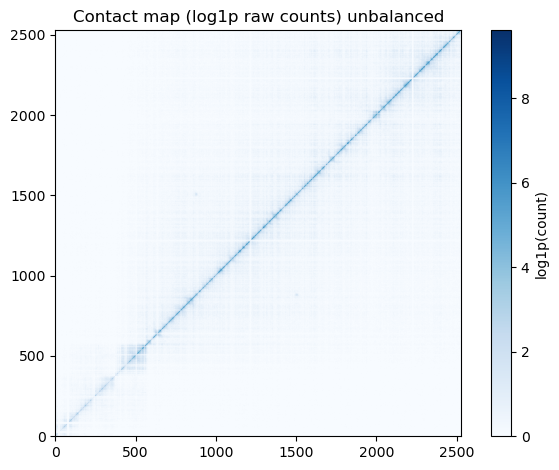

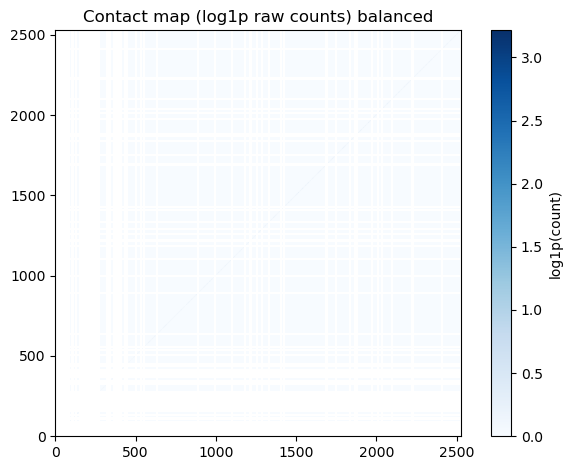

In [10]:
clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250727_merged_PnMs.filt.pairs.mcool::/resolutions/10000")


mat = clr.matrix(balance=False).fetch("2R_JJg14_057")

print("Matrix stats:")
print(f"Max value: {np.max(mat)}")
print(f"Min value: {np.min(mat)}")
print(f"NaNs present: {np.isnan(mat).any()}")
print(f"Rows with all zeros: {np.sum(np.all(mat == 0, axis=1))}")
print(f"Columns with all zeros: {np.sum(np.all(mat == 0, axis=0))}")

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts) unbalanced")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

mat = clr.matrix(balance=True).fetch("2R_JJg14_057")
mat = np.clip(mat, 0, np.percentile(mat, 99))  

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts) balanced")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

Try 100k

Matrix stats:
Max value: 70100
Min value: 0
NaNs present: False
Rows with all zeros: 0
Columns with all zeros: 0


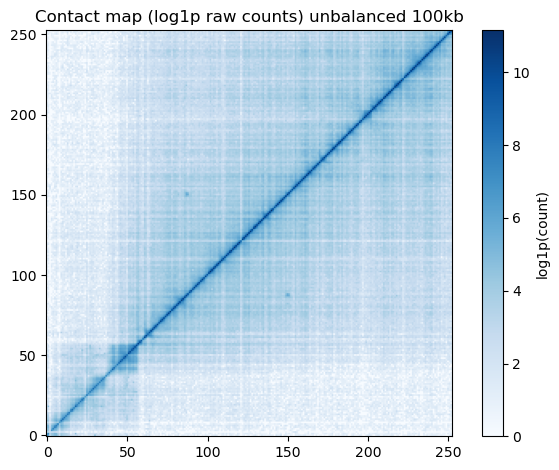

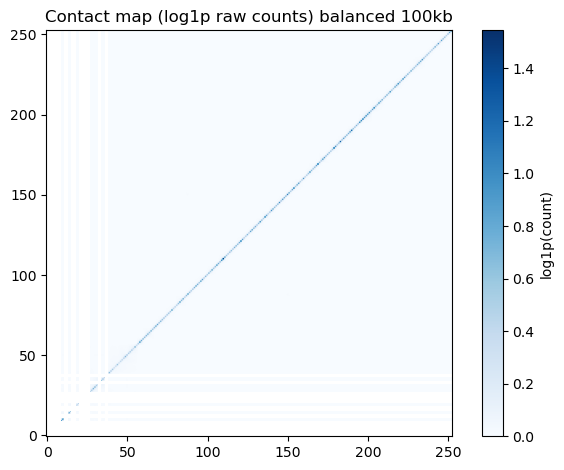

In [11]:
clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250727_merged_PnMs.filt.pairs.mcool::/resolutions/100000")


mat = clr.matrix(balance=False).fetch("2R_JJg14_057")

print("Matrix stats:")
print(f"Max value: {np.max(mat)}")
print(f"Min value: {np.min(mat)}")
print(f"NaNs present: {np.isnan(mat).any()}")
print(f"Rows with all zeros: {np.sum(np.all(mat == 0, axis=1))}")
print(f"Columns with all zeros: {np.sum(np.all(mat == 0, axis=0))}")

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts) unbalanced 100kb")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

mat = clr.matrix(balance=True).fetch("2R_JJg14_057")
mat = np.clip(mat, 0, np.percentile(mat, 99))  

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts) balanced 100kb")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

Matrix stats:
Max value: 2420
Min value: 0
NaNs present: False
Rows with all zeros: 11
Columns with all zeros: 11


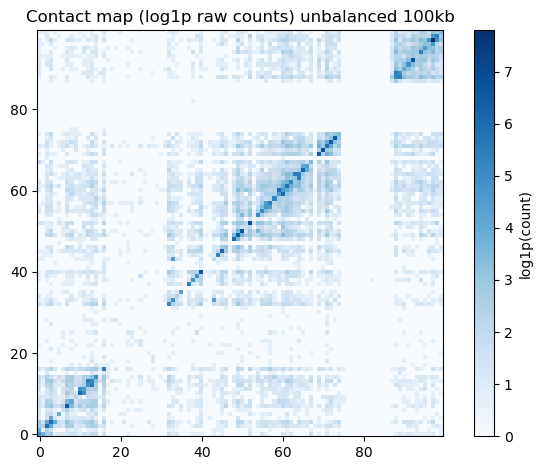

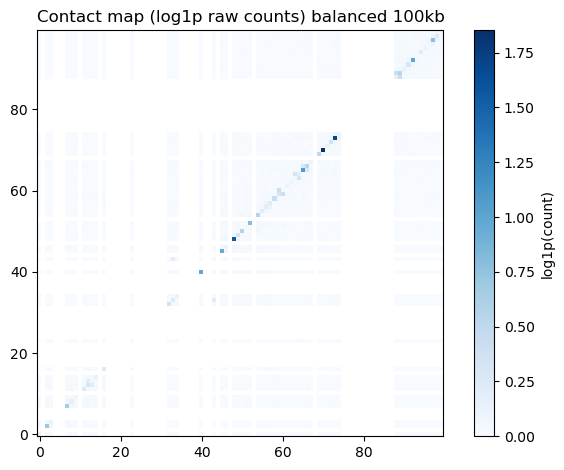

In [ ]:
clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250727_merged_PnMs.filt.pairs.mcool::/resolutions/10000")


mat = clr.matrix(balance=False).fetch("2R_JJg14_057:0-1000000")

print("Matrix stats:")
print(f"Max value: {np.max(mat)}")
print(f"Min value: {np.min(mat)}")
print(f"NaNs present: {np.isnan(mat).any()}")
print(f"Rows with all zeros: {np.sum(np.all(mat == 0, axis=1))}")
print(f"Columns with all zeros: {np.sum(np.all(mat == 0, axis=0))}")

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts) unbalanced 10kb")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

mat = clr.matrix(balance=True).fetch("2R_JJg14_057:0-1000000")
mat = np.clip(mat, 0, np.percentile(mat, 99))  

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("Contact map (log1p raw counts) balanced 10kb")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

Filtering the short 

In [ ]:
(hic_env) erikson@longus2:/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools$ pairtools select '(chrom1 != chrom2) or (abs(pos2 - pos1) >= 10000)' \
  -o 20250727_merged_PnMs.filteredShortReads.pairs \
  20250727_merged_PnMs.filt.pairs


cooler cload pairs -c1 2 -p1 3 -c2 4 -p2 5 /data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/diploid_genome.importantChroms.chromsizes:10000 20250727_merged_PnMs.filteredShortReads.pairs.gz 20250727_merged_PnMs.filteredShortReads.pairs.cool

cooler balance 20250727_merged_PnMs.filteredShortReads.pairs.cool

cooler zoomify 20250727_merged_PnMs.filteredShortReads.pairs.cool -o 20250727_merged_PnMs.filteredShortReads.pairs.mcool --resolutions 10000,20000,40000,50000,100000

cooler balance 20250727_merged_PnMs.filteredShortReads.pairs.mcool::/resolutions/20000



Matrix stats:
Max value: 1741
Min value: 0
NaNs present: False
Rows with all zeros: 7
Columns with all zeros: 7


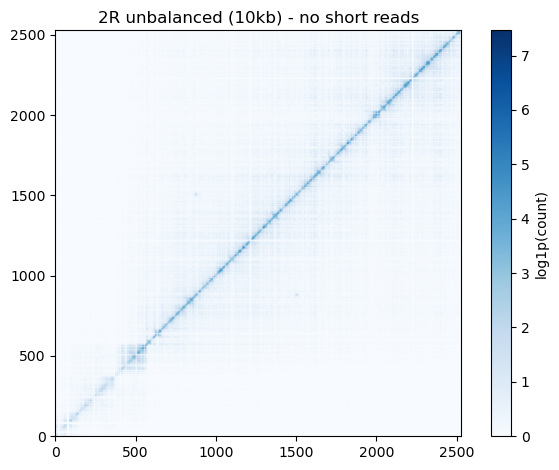

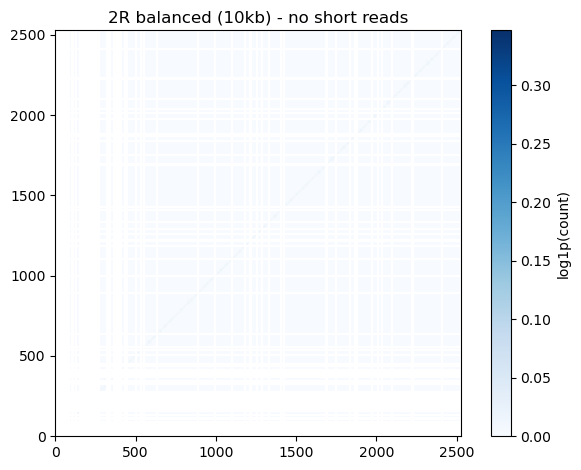

In [12]:
clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250727_merged_PnMs.filteredShortReads.pairs.mcool::/resolutions/10000")


mat = clr.matrix(balance=False).fetch("2R_JJg14_057")

print("Matrix stats:")
print(f"Max value: {np.max(mat)}")
print(f"Min value: {np.min(mat)}")
print(f"NaNs present: {np.isnan(mat).any()}")
print(f"Rows with all zeros: {np.sum(np.all(mat == 0, axis=1))}")
print(f"Columns with all zeros: {np.sum(np.all(mat == 0, axis=0))}")

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("2R unbalanced (10kb) - no short reads")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

mat = clr.matrix(balance=True).fetch("2R_JJg14_057")
mat = np.clip(mat, 0, np.percentile(mat, 99))  

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("2R balanced (10kb) - no short reads")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

Matrix stats:
Max value: 6677
Min value: 0
NaNs present: False
Rows with all zeros: 0
Columns with all zeros: 0


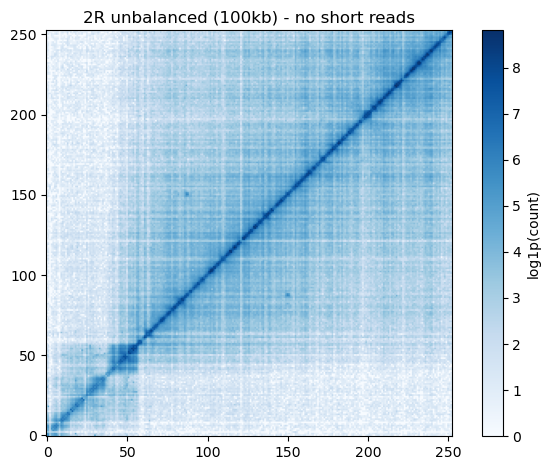

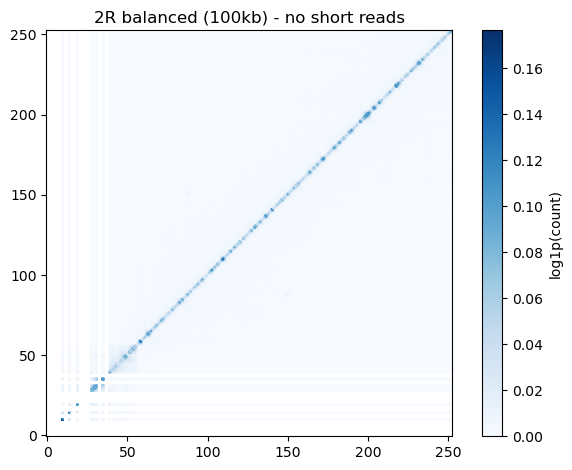

In [14]:
clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250727_merged_PnMs.filteredShortReads.pairs.mcool::/resolutions/100000")


mat = clr.matrix(balance=False).fetch("2R_JJg14_057")

print("Matrix stats:")
print(f"Max value: {np.max(mat)}")
print(f"Min value: {np.min(mat)}")
print(f"NaNs present: {np.isnan(mat).any()}")
print(f"Rows with all zeros: {np.sum(np.all(mat == 0, axis=1))}")
print(f"Columns with all zeros: {np.sum(np.all(mat == 0, axis=0))}")

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("2R unbalanced (100kb) - no short reads")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

mat = clr.matrix(balance=True).fetch("2R_JJg14_057")
mat = np.clip(mat, 0, np.percentile(mat, 99))  

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("2R balanced (100kb) - no short reads")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

#zoom in region

Matrix stats:
Max value: 80
Min value: 0
NaNs present: False
Rows with all zeros: 11
Columns with all zeros: 11


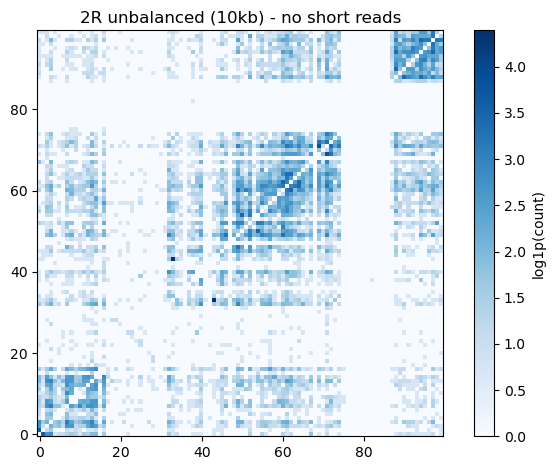

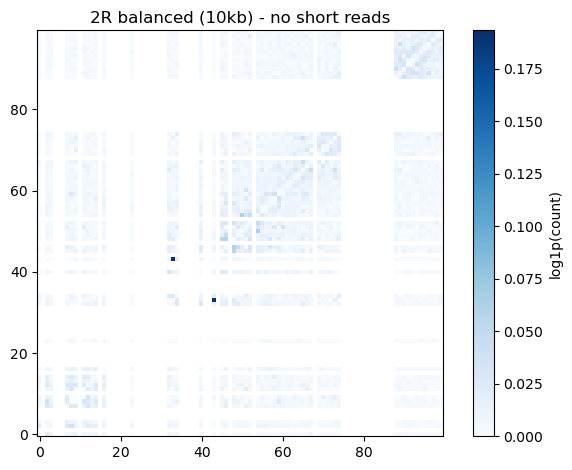

In [21]:
#zoom in region
clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250727_merged_PnMs.filteredShortReads.pairs.mcool::/resolutions/10000")


mat = clr.matrix(balance=False).fetch("2R_JJg14_057:0-1000000")

print("Matrix stats:")
print(f"Max value: {np.max(mat)}")
print(f"Min value: {np.min(mat)}")
print(f"NaNs present: {np.isnan(mat).any()}")
print(f"Rows with all zeros: {np.sum(np.all(mat == 0, axis=1))}")
print(f"Columns with all zeros: {np.sum(np.all(mat == 0, axis=0))}")

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("2R unbalanced (10kb) - no short reads")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

mat = clr.matrix(balance=True).fetch("2R_JJg14_057:0-1000000")
mat = np.clip(mat, 0, np.percentile(mat, 99))  

plt.imshow(np.log1p(mat), cmap="Blues", origin="lower")
plt.title("2R balanced (10kb) - no short reads")
plt.colorbar(label='log1p(count)')
plt.tight_layout()
plt.show()

Are the loops visible at this resolution

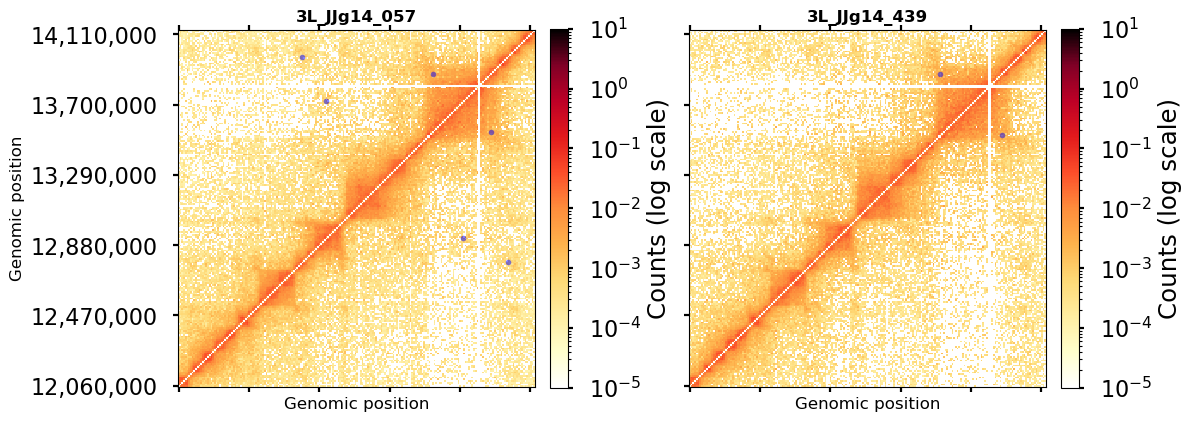

In [44]:
import cooltools.lib.plotting

clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250727_merged_PnMs.filteredShortReads.pairs.mcool::/resolutions/10000")
loops = pd.read_csv('/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250709_PnMs_merged_diploidGenome.20kb.loops.bedpe', sep='\t', header=None)
loops.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']

# Regions and constants
#region1 = '2L_JJg14_057:500000-21830000'
#region2 = '2L_JJg14_439:500000-21830000'

region1 = '3L_JJg14_057:12060000-14140000'
region2 = '3L_JJg14_439:12060000-14140000'
bin_size = clr.binsize
norm = LogNorm(vmin=1e-5, vmax=10)
fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)
bp_formatter = EngFormatter(sep="")

def format_ticks(ax, x=True, y=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
    ax.tick_params(axis='x', rotation=45)

def plot_loops_on_ax(ax, region, loops, bin_size, color='blue'):
    chrom, coords = region.split(':')
    start, end = map(int, coords.split('-'))
    #start, end = 30_000_000, 10_000_000
    for _, row in loops.iterrows():
        if row['chrom1'] == row['chrom2'] == chrom:
            b1 = (row['start1'] - start) // bin_size
            b2 = (row['start2'] - start) // bin_size
            if 0 <= b1 <= (end - start) // bin_size and 0 <= b2 <= (end - start) // bin_size:
                ax.plot(b2, b1, 'o', color=color, alpha=0.5, markersize=4)
                ax.plot(b1, b2, 'o', color=color, alpha=0.5, markersize=4)

# Create only bottom 2 log-scale subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
regions = [region1, region2]

for ax, region in zip(axs, regions):
    matrix = clr.matrix(balance=True).fetch(region)
    matrix = np.ma.masked_invalid(matrix)
    im = ax.matshow(matrix, cmap='fall', norm=norm, origin='lower')

    plot_loops_on_ax(ax, region, loops, bin_size, color='blue')
    reg=region.split(':')[0]
    ax.set_title(f"{reg}", fontsize=12, fontweight='bold')
    # Set genomic coordinate ticks
    chrom, coords = region.split(':')
    start, end = map(int, coords.split('-'))
    num_bins = matrix.shape[0]
    ticks = [i for i in range(0, num_bins, num_bins // 5)]  # adjust 5 to control number of ticks
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_yticklabels([f"{start + i * bin_size:,}" for i in ticks])
    ax.set_xticklabels(['' for _ in ticks])  # If you want no X labels


    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Counts (log scale)')

# Axis labels
axs[0].set_ylabel('Genomic position', fontsize=12)
for ax in axs:
    ax.set_xlabel('Genomic position', fontsize=12)

plt.tight_layout()
plt.show()

Coolers 100kb - filtered short reads

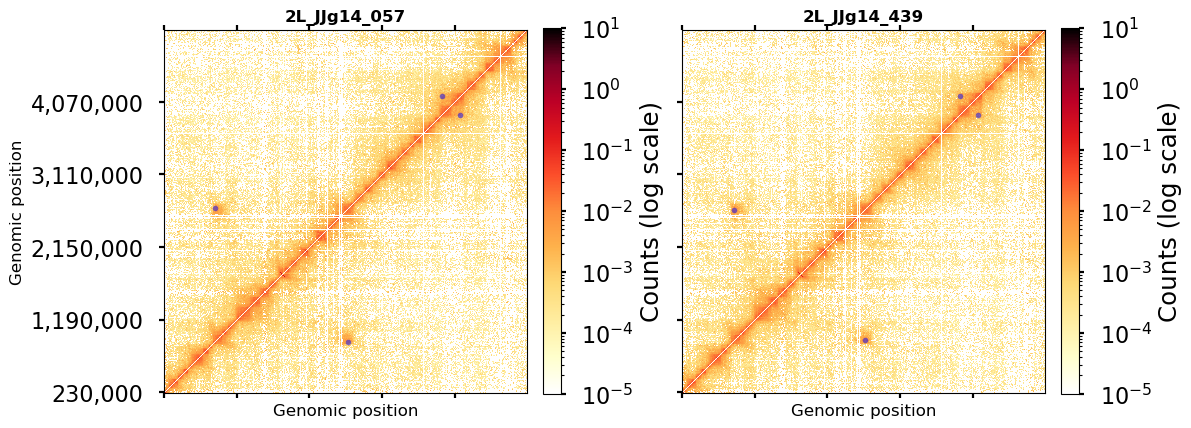

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cooler
from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter
import cooltools.lib.plotting

# Load cooler and loops
clr = cooler.Cooler("/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250727_merged_PnMs.filteredShortReads.pairs.mcool::/resolutions/10000")
loops = pd.read_csv('/data/alhajabed/FlyHiC/PoreC/20250625_balancedMcools/20250709_PnMs_merged_diploidGenome.20kb.loops.bedpe', sep='\t', header=None)
loops.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']

# Regions and constants
#region1 = '2L_JJg14_057:500000-21830000'
#region2 = '2L_JJg14_439:500000-21830000'

region1 = '2L_JJg14_057:230000-5030000'
region2 = '2L_JJg14_439:230000-5030000'
bin_size = clr.binsize
norm = LogNorm(vmin=1e-5, vmax=10)
fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)
bp_formatter = EngFormatter(sep="")

def format_ticks(ax, x=True, y=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
    ax.tick_params(axis='x', rotation=45)

def plot_loops_on_ax(ax, region, loops, bin_size, color='blue'):
    chrom, coords = region.split(':')
    start, end = map(int, coords.split('-'))
    #start, end = 30_000_000, 10_000_000
    for _, row in loops.iterrows():
        if row['chrom1'] == row['chrom2'] == chrom:
            b1 = (row['start1'] - start) // bin_size
            b2 = (row['start2'] - start) // bin_size
            if 0 <= b1 <= (end - start) // bin_size and 0 <= b2 <= (end - start) // bin_size:
                ax.plot(b2, b1, 'o', color=color, alpha=0.5, markersize=4)
                ax.plot(b1, b2, 'o', color=color, alpha=0.5, markersize=4)

# Create only bottom 2 log-scale subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
regions = [region1, region2]

for ax, region in zip(axs, regions):
    matrix = clr.matrix(balance=True).fetch(region)
    matrix = np.ma.masked_invalid(matrix)
    im = ax.matshow(matrix, cmap='fall', norm=norm, origin='lower')

    plot_loops_on_ax(ax, region, loops, bin_size, color='blue')
    reg=region.split(':')[0]
    ax.set_title(f"{reg}", fontsize=12, fontweight='bold')
    # Set genomic coordinate ticks
    chrom, coords = region.split(':')
    start, end = map(int, coords.split('-'))
    num_bins = matrix.shape[0]
    ticks = [i for i in range(0, num_bins, num_bins // 5)]  # adjust 5 to control number of ticks
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_yticklabels([f"{start + i * bin_size:,}" for i in ticks])
    ax.set_xticklabels(['' for _ in ticks])  # If you want no X labels


    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Counts (log scale)')

# Axis labels
axs[0].set_ylabel('Genomic position', fontsize=12)
for ax in axs:
    ax.set_xlabel('Genomic position', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
Filtering the shory read pairs that are 100000bp apart or more
pairtools select '(chrom1 != chrom2) or (abs(pos2 - pos1) >= 100000)'   -o 20250727_merged_PnMs.filteredShortReads.100kb.pairs   20250727_merged_PnMs.filt.pairs

